In [274]:
import pandas as pd # to use or generate dataframe
import seaborn as sns # for pretty plots
import numpy as np # for matrix manipulation
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [276]:
%cd C:\\Users\\emper\\OneDrive\\Desktop\\DSTI\\Pratical-Intro-to-Data-Science\\Final-Project

C:\Users\emper\OneDrive\Desktop\DSTI\Pratical-Intro-to-Data-Science\Final-Project


**Let's do classification by East west**

In [333]:
Model_Classification_data = pd.read_csv("model_classification.csv")

In [337]:
Model_Classification_data.describe()

,year,AvgTemp,af,rain,sun,lat,lon
count,28154.000000,28154.000000,28154.000000,28154.000000,27880.000000,28154.000000,28154.000000
mean,1979.320345,9.454912,3.431306,72.044807,118.450276,53.974852,-2.583117
std,27.199292,4.509328,5.176972,48.048325,63.196272,2.542231,2.173804
min,1890.000000,-4.650000,0.000000,0.000000,2.800000,50.218000,-6.880000
25%,1962.000000,5.750000,0.000000,38.400000,64.800000,51.911000,-3.820000
50%,1982.000000,9.050000,0.000000,61.700000,111.950000,53.356000,-2.270000
75%,2000.000000,13.300000,5.000000,94.000000,163.600000,55.846000,-1.260000
max,2023.000000,22.450000,31.000000,568.800000,350.300000,60.139000,1.727000


In [335]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [340]:
# New function: classify based on longitude
def assign_region(lon):
    if lon >= -2.5765:  # Midpoint between max (1.727) and min (-6.880)
        return 'Eastern Half'
    else:
        return 'Western Half'

# Apply the new function
Model_Classification_data['Region_Label'] = Model_Classification_data['lon'].apply(assign_region)


In [342]:
# Drop unneeded columns including 'region' and 'latitude'
features = Model_Classification_data.drop(columns=['station', 'year','lat', 'region', 'AvgTemp'])
target = Model_Classification_data['Region_Label']
Model_Classification_data

,station,year,month,AvgTemp,af,rain,sun,lat,lon,region,Region_Label
0,aberporth,1957,Jan,6.25,2.0,80.6,55.6,52.140,-4.57,Wales,Western Half
1,aberporth,1957,Feb,5.85,2.0,85.1,105.2,52.140,-4.57,Wales,Western Half
2,aberporth,1957,Mar,9.80,0.0,83.1,98.3,52.140,-4.57,Wales,Western Half
3,aberporth,1957,Apr,8.75,0.0,7.4,181.1,52.140,-4.57,Wales,Western Half
4,aberporth,1957,May,10.50,0.0,54.1,268.7,52.140,-4.57,Wales,Western Half
...,...,...,...,...,...,...,...,...,...,...,...
28149,yeovilton,2023,Mar,7.90,2.0,113.2,55.7,51.006,-2.64,South West England,Western Half
28150,yeovilton,2023,Apr,9.15,4.0,59.6,137.3,51.006,-2.64,South West England,Western Half
28151,yeovilton,2023,May,13.00,0.0,68.4,231.1,51.006,-2.64,South West England,Western Half
28152,yeovilton,2023,Jun,17.70,0.0,22.8,254.9,51.006,-2.64,South West England,Western Half


In [344]:
Group_by_Label = Model_Classification_data.groupby('Region_Label')
Group_by_Label['station'].count()

Region_Label
Eastern Half    14096
Western Half    14058
Name: station, dtype: int64

<Axes: title={'center': 'Distribution of the Station by Region'}, xlabel='Region_Label'>

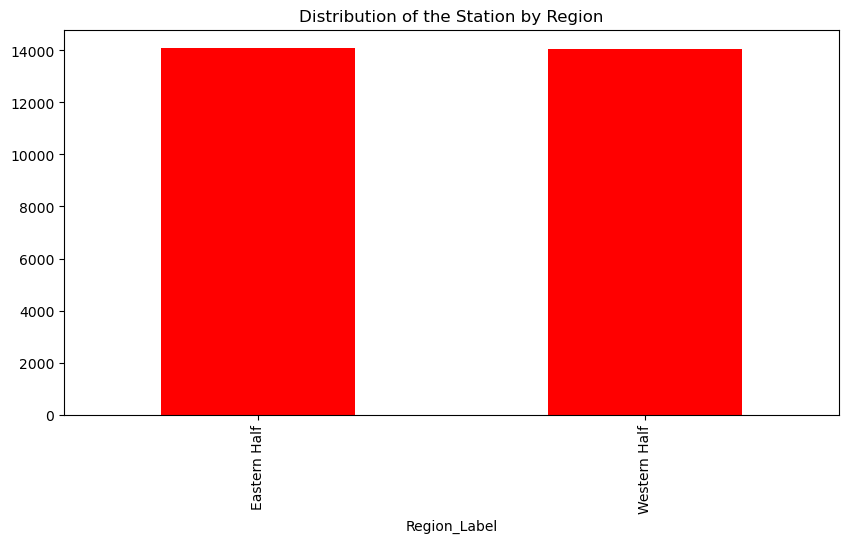

In [346]:
Group_by_Label['station'].count().plot(kind= 'bar', title= 'Distribution of the Station by Region', figsize = (10, 5), color ='red')

In [348]:
# One-hot encode 'month'
categorical_features = ['month']
numeric_features = features.drop(columns=categorical_features).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
    ],
    remainder='passthrough'  # Leave numeric features unchanged
)

In [350]:
# Step 1: Map each station to its most common Region_Label (usually one per station)
station_to_region = Model_Classification_data.groupby('station')['Region_Label'].agg(lambda x: x.mode()[0])

# Step 2: Stratified split of station names based on their region
train_stations, test_stations = train_test_split(
    station_to_region.index,
    test_size=0.3,
    stratify=station_to_region,
    random_state=42
)

# Step 3: Split the actual data using station names
train_data = Model_Classification_data[Model_Classification_data['station'].isin(train_stations)]
test_data = Model_Classification_data[Model_Classification_data['station'].isin(test_stations)]

# Step 4: Define features and target
X_train = train_data.drop(columns=['station', 'year', 'lat', 'Region_Label', 'region'])
y_train = train_data['Region_Label']
X_test = test_data.drop(columns=['station', 'year', 'lat', 'Region_Label', 'region'])
y_test = test_data['Region_Label']


In [352]:
#Let's define and train the model pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

In [354]:
#Let's set the evaluation metrix
# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

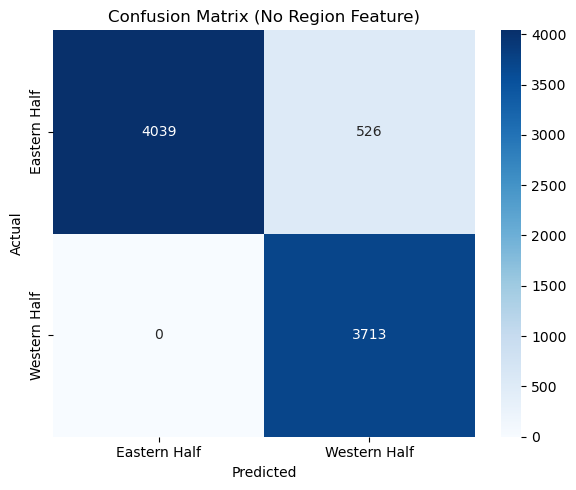

In [356]:
#Let's plot the confusion matrix

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf_pipeline.classes_,
            yticklabels=clf_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (No Region Feature)')
plt.tight_layout()
plt.savefig("confusion_matrix_no_region.png")

report_df = pd.DataFrame(report).transpose()
report_df_rounded = report_df.round(2)

In [358]:
from IPython.display import display

display(report_df_rounded)

,precision,recall,f1-score,support
Eastern Half,1.00,0.88,0.94,4565.00
Western Half,0.88,1.00,0.93,3713.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,8278.00
weighted avg,0.94,0.94,0.94,8278.00


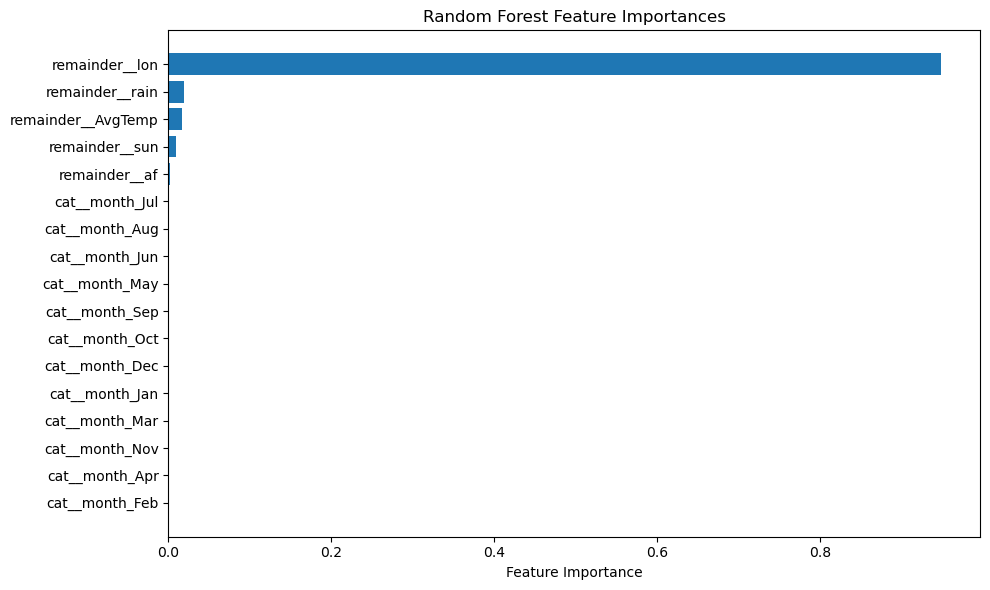

In [360]:

# Make sure your pipeline is already fitted
# clf_pipeline.fit(X_train, y_train)

# Get feature importances
importances = clf_pipeline.named_steps['classifier'].feature_importances_

# Get full feature names after preprocessing
feature_names = clf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Combine into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


**Let's Look at Happiness Vs Earnings**

In [278]:
# Step 1: Load both files
happiness = pd.read_csv('Happiness_only.csv')
earnings = pd.read_csv('Weekly earning by boroughs.csv')


In [280]:
# Step 2: Inspect columns (quick check)
print(happiness.columns)
print(earnings.columns)

Index(['Area Codes', 'Area names', 'Borough', 'Unnamed: 3',
       'Per cent in each category on 11 point scale3:', 'Medium', 'High',
       'Very High', 'Means', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24'],
      dtype='object')
Index(['Borough', 'Code', 'N of jobs (thousands)', 'Median',
       'Annual percent change', 'Mean', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'],
      dtype='object')


In [282]:
# Step 3: Rename important columns correctly
# Adjust depending on the new actual names
happiness = happiness.rename(columns={
    'Borough': 'borough',  # if it's already 'borough', no change needed
    'Means': 'average_happiness'
})

earnings = earnings.rename(columns={
    'Borough': 'borough',  # if it's already 'borough', no change needed
    'Median': 'median_earnings'
})

In [284]:

# Step 4: Clean borough names to avoid merge issues (remove spaces, lowercase)
happiness['borough'] = happiness['borough'].str.strip().str.lower()
earnings['borough'] = earnings['borough'].str.strip().str.lower()

In [286]:
#Keep only earnings where borough is in happiness list
earnings = earnings[earnings['borough'].isin(happiness['borough'])]

In [288]:
#Now select and merge
happiness_clean = happiness[['borough', 'average_happiness']]
earnings_clean = earnings[['borough', 'median_earnings']]

In [290]:
# Step 6: Merge the datasets on 'borough'
happiness_vs_earnings = pd.merge(happiness_clean, earnings_clean, on='borough', how='inner')

In [292]:
happiness_vs_earnings.head(50)

,borough,average_happiness,median_earnings
0,NaN,7.46,NaN
1,NaN,7.46,NaN
2,NaN,7.46,NaN
3,NaN,7.46,NaN
4,NaN,7.45,NaN
5,NaN,7.45,NaN
6,NaN,7.45,NaN
7,NaN,7.45,NaN
8,NaN,7.34,NaN
9,NaN,7.34,NaN


In [294]:
happiness_vs_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   borough            354 non-null    object
 1   average_happiness  410 non-null    object
 2   median_earnings    354 non-null    object
dtypes: object(3)
memory usage: 11.7+ KB


In [296]:
happiness_vs_earnings.to_csv('happiness_vs_earnings.csv', index=False)


In [298]:
happiness_vs_earnings = pd.read_csv('happiness_vs_earnings.csv')

In [300]:
happiness_vs_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   borough            354 non-null    object
 1   average_happiness  410 non-null    object
 2   median_earnings    354 non-null    object
dtypes: object(3)
memory usage: 11.7+ KB


In [304]:
happiness_vs_earnings['average_happiness'] = pd.to_numeric(happiness_vs_earnings['average_happiness'], errors= 'coerce')

In [306]:
happiness_vs_earnings['median_earnings'] = pd.to_numeric(happiness_vs_earnings['median_earnings'], errors= 'coerce')

In [308]:
happiness_vs_earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            354 non-null    object 
 1   average_happiness  409 non-null    float64
 2   median_earnings    353 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.7+ KB


In [310]:
happiness_vs_earnings.describe()

,average_happiness,median_earnings
count,409.000000,353.000000
mean,7.482421,624.545892
std,0.197820,72.884827
min,6.890000,488.700000
25%,7.370000,571.300000
50%,7.460000,607.400000
75%,7.600000,663.700000
max,8.210000,843.300000


In [314]:
key_columns = ['average_happiness', 'median_earnings']

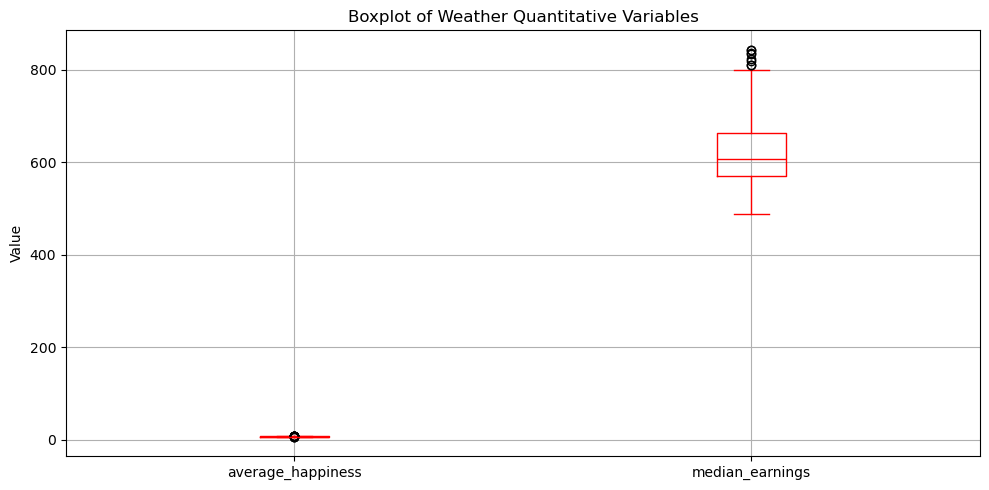

In [320]:
plt.figure(figsize=(10, 5))
happiness_vs_earnings.boxplot(column=key_columns, color='red')
plt.title("Boxplot of Weather Quantitative Variables")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

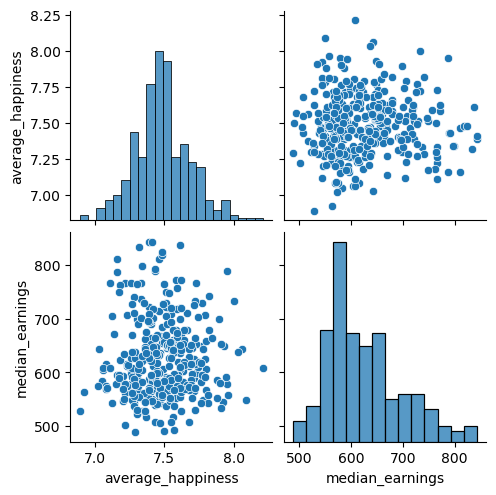

In [322]:
sns.pairplot(happiness_vs_earnings[key_columns])

<Axes: >

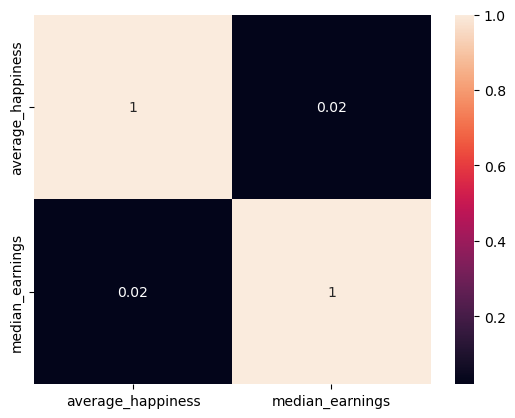

In [324]:
#Let's use Scatter Plot Heatmap to see the correlation index between the variables
correlation = happiness_vs_earnings[key_columns].corr().round(2)
sns.heatmap(correlation, annot = True)